User Input (Natural Language)
        ↓
     LLM (Brain)
        ↓
  Does it need a tool?
     ┌───────────────┐
     │               │
   YES             NO
     │               │
Call Tool        Final Answer
     │
Observe Result
     │
Back to LLM (Reason again)


In [22]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [23]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
arxiv.name

'arxiv'

In [24]:
arxiv.invoke("Attention is all you need?")

'Published: 2018-06-28\nTitle: Quit When You Can: Efficient Evaluation of Ensembles with Ordering Optimization\nAuthors: Serena Wang, Maya Gupta, Seungil You\nSummary: Given a classifier ensemble and a set of examples to be classified, many examples may be confidently and accurately classified after only a subset of the base models in the ensemble are evaluated. This can reduce both mean latency and CPU while maintaining the high accuracy of the original ensemble. To achieve such gains, we propose j'

In [25]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [26]:
wiki.invoke("What is Gen Ai?")

"Page: Generation Beta\nSummary: Generation Beta, often shortened to Gen Beta, is the proposed name for the demographic cohort succeeding Generation Alpha. The name was coined by futurist and demographer Mark McCrindle, who also coined the name Generation Alpha. He defines the cohort as those born from 2025 to 2039 and this definition has been reported by numerous sources citing McCrindle.\nMcCrindle expects the generation's members to be primarily the children of younger millennials and Generation"

In [27]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-agent"

In [28]:
### Custom Functions

def multiply(a :int,b:int)->int:
    """ Multiply a and b.
    
    Args:
        a:first int
        b: second int
    """

    return a*b

## This will be a tool

def add(a:int , b:int) ->int :
    """ Adds a and b.
    
    Args.:
        a: first int
        b: second int
    """

    return a+b

def divide(a: int ,b :int) ->float:
    """ Divide a and b.
    
    Args:
    a: first int
    b: second int
    
    """
    return a/b



In [29]:
tools=[arxiv,wiki,add,multiply,divide]


In [30]:
### Initialize my LLM Model

from langchain_groq import ChatGroq

llm=ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools=llm.bind_tools(tools)

In [31]:
from pprint import pprint
from langchain_core.messages import AIMessage,HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'mhwbcfes7', 'function': {'arguments': '{"query":"Recent AI News"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 648, 'total_tokens': 681, 'completion_time': 0.085318452, 'completion_tokens_details': None, 'prompt_time': 0.040325722, 'prompt_tokens_details': None, 'queue_time': 0.058468678, 'total_time': 0.125644174}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c6739-05f4-7d80-b85e-ebbdd99ffca9-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Recent AI News'}, 'id': 'mhwbcfes7', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 648, 'output_tokens': 33, 'total_tokens': 681})

In [32]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'wikipedia',
  'args': {'query': 'Recent AI News'},
  'id': 'm5pskz0f0',
  'type': 'tool_call'}]

In [38]:
# State Schema

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

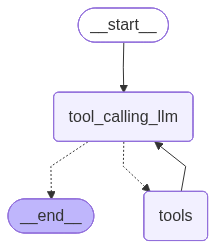

In [39]:
### Entire Chatbot With LangGraph

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

#Node Defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

#Build Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", 
                              tools_condition
                              )
builder.add_edge("tools","tool_calling_llm")  # in ReAct agents this occured

graph=builder.compile()

#View
display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the op 10 recent AI new for Feb 16 2026")})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the op 10 recent AI new for Feb 16 2026
================================== Ai Message ==================================
Tool Calls:
  wikipedia (zan6r2vne)
 Call ID: zan6r2vne
  Args:
    query: Recent AI news February 16 2026
  wikipedia (ed01r6fp1)
 Call ID: ed01r6fp1
  Args:
    query: Top AI news stories 2026
  wikipedia (ev2akjcr7)
 Call ID: ev2akjcr7
  Args:
    query: AI news February 10-16 2026
  arxiv (exn4pedqa)
 Call ID: exn4pedqa
  Args:
    query: Recent AI research February 16 2026
  arxiv (pktr3rd29)
 Call ID: pktr3rd29
  Args:
    query: Recent AI publications February 10-16 2026
================================= Tool Message =================================
Name: wikipedia

Page: AI slop
Summary: AI slop (known simply as slop) is digital content made with generative artificial intelligence that is lacking in effort, quality, or meaning, and produced in high volume as clickbai

In [41]:
messages=graph.invoke({"messages":HumanMessage(content="What is Machine Learning?")})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is Machine Learning?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (e1mrfvt39)
 Call ID: e1mrfvt39
  Args:
    query: Machine Learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
================================== Ai Message ==================================
Tool Calls:
  wikipedia (0aa1pvhsr)
 Ca

In [43]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the op 2 recent AI new for Feb 16 2026,add 5+5 then divide by 10")})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the op 2 recent AI new for Feb 16 2026,add 5+5 then divide by 10
================================== Ai Message ==================================
Tool Calls:
  wikipedia (wy6w3vaqb)
 Call ID: wy6w3vaqb
  Args:
    query: Feb 16 2026 AI news
  wikipedia (vk33k7x1a)
 Call ID: vk33k7x1a
  Args:
    query: Feb 16 2026 AI news 2
  add (hfwbch535)
 Call ID: hfwbch535
  Args:
    a: 5
    b: 5
  divide (m0554e3sb)
 Call ID: m0554e3sb
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: wikipedia

Page: Timeline of the second Trump presidency (2026 Q1)
Summary: The following is a timeline of the second presidency of Donald Trump during the first quarter of 2026, from January 1, 2026, to March 31, 2026. To navigate between quarters, see timeline of the Donald Trump presidencies.

Page: 2026 in the United States
Summary: The following is a lis

### Agent memory

Aim

Lets introduce Agent With Memory

In [45]:
messages=graph.invoke({"messages":HumanMessage(content=" What is 5+5 ?")})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

 What is 5+5 ?
================================== Ai Message ==================================
Tool Calls:
  add (y3aa75f33)
 Call ID: y3aa75f33
  Args:
    a: 5
    b: 5
================================= Tool Message =================================
Name: add

10
================================== Ai Message ==================================

The result of 5+5 is 10.


In [48]:
messages=graph.invoke({"messages":HumanMessage(content="divide that by 5")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

divide that by 5
================================== Ai Message ==================================

I don't see any numbers to divide. To divide numbers, you can use the 'divide' function. For example:
Tool Calls:
  divide (vdcf3khem)
 Call ID: vdcf3khem
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: divide

2.0
================================== Ai Message ==================================

The result of the division is 2.0.


### MemorySaver

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built -in persistence layer gives us memory,allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-Memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [49]:
### Entire Chatbot With LangGraph

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

#Node Defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

#Build Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", 
                              tools_condition
                              )
builder.add_edge("tools","tool_calling_llm")  # in ReAct agents this occured



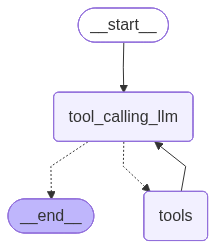

In [50]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_memory=builder.compile(checkpointer=memory)

#View
display(Image(graph.get_graph().draw_mermaid_png()))

In [55]:
## Specify the thread 

config= {"configurable":{"thread_id":"1"}}

#Specify an input
messages=[HumanMessage(content="Add 12 and 4")]
messages=graph_memory.invoke({"messages":messages}, config=config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 4
================================== Ai Message ==================================
Tool Calls:
  add (b6a6rdedx)
 Call ID: b6a6rdedx
  Args:
    a: 12
    b: 4
================================= Tool Message =================================
Name: add

16
================================== Ai Message ==================================

The result of the function call was 16, which was the expected answer.


In [56]:
messages=[HumanMessage(content="Add that number to 20")]
messages=graph_memory.invoke({"messages":messages}, config=config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 4
================================== Ai Message ==================================
Tool Calls:
  add (b6a6rdedx)
 Call ID: b6a6rdedx
  Args:
    a: 12
    b: 4
================================= Tool Message =================================
Name: add

16
================================== Ai Message ==================================

The result of the function call was 16, which was the expected answer.
================================ Human Message =================================

Add that number to 20
================================== Ai Message ==================================
Tool Calls:
  add (rphfgnysf)
 Call ID: rphfgnysf
  Args:
    a: 16
    b: 20
================================= Tool Message =================================
Name: add

36
================================== Ai Message ==================================

The result of the function call was 36.
